<a href="https://colab.research.google.com/github/aaubs/ds-master/blob/main/notebooks/M3_LSTM_stock_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series with LSTM

In this notebook we will be using an LSTM architecture to work with simple stock price (change) prediciton.
We will look at simple 1-step ahead prediction and finally evaluate the performance of the model using a "naive backtesting" approach. Here the question is: How much money would we have gained/lost if we followed the predictions of the network.

In [1]:
# First: Let's install the data-reader to get some current stock prices
!pip install --upgrade pandas-datareader -q

     |████████████████████████████████| 109 kB 5.3 MB/s 


In [2]:
# Import basic packaging

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from pandas_datareader import data as pdr
import datetime as dt

import seaborn as sns
sns.set()

In [3]:
# set timeframe for data extraction

start = dt.datetime(2021,1,1)
end = dt.datetime.now()

In [4]:
# get the data

data =  pdr.DataReader("^OMXC25",'yahoo', start=start, end=end)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 466 entries, 2021-01-04 to 2022-11-16
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       466 non-null    float64
 1   Low        466 non-null    float64
 2   Open       466 non-null    float64
 3   Close      466 non-null    float64
 4   Volume     466 non-null    float64
 5   Adj Close  466 non-null    float64
dtypes: float64(6)
memory usage: 25.5 KB


In [6]:
# calculate diffs - changes to previous period
data_diff = data.diff()

In [7]:
# alternatively
#data_diff = data.pct_change()

In [8]:
data_diff

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-01-04,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-05,-5.730103,-8.039917,9.969971,-20.960083,835800.0,-20.960083
2021-01-07,-1.250000,7.119995,-12.199951,11.300049,2554500.0,11.300049
2021-01-08,15.550049,11.149902,20.149902,14.679932,-2027700.0,14.679932
2021-01-11,-10.800049,-13.289917,-8.959961,-16.029907,-1016400.0,-16.029907
...,...,...,...,...,...,...
2022-11-10,64.619995,0.780029,-11.940063,62.150024,7144200.0,62.150024
2022-11-11,-1.729980,42.920044,76.300049,-22.440063,-3125600.0,-22.440063
2022-11-14,-18.690063,-1.359985,-31.020020,0.200073,-3139900.0,0.200073


Here we will be using diffs to predict diffs ahead.

In [9]:
# import packaging for Neural Net
import math

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

We willpreprocess the data by MinMax scaling between -1 and 1

In [10]:
# normalizing
scaler = MinMaxScaler(feature_range=(-1, 1))
data_diff['Adj_Close_scaled'] = scaler.fit_transform(data_diff['Adj Close'].values.reshape(-1, 1))

In [11]:
# create targets by shifting
data_diff['Adj_Close_scaled+1'] = data_diff.Adj_Close_scaled.shift(-1, fill_value=data_diff.Adj_Close_scaled.iloc[-1])

In [12]:
# get the data as matrix
data_p = data_diff.iloc[1:,6:].values.astype('float32')

This is how our dataframe looks. X is change in t; y is change in t+1

In [13]:
data_p

array([[-1.99693233e-01,  2.13924736e-01],
       [ 2.13924736e-01,  2.57259339e-01],
       [ 2.57259339e-01, -1.36481807e-01],
       [-1.36481807e-01, -2.64183372e-01],
       [-2.64183372e-01,  1.59817502e-01],
       [ 1.59817502e-01,  1.31611198e-01],
       [ 1.31611198e-01, -1.73023865e-01],
       [-1.73023865e-01,  2.00205028e-01],
       [ 2.00205028e-01,  3.12135041e-01],
       [ 3.12135041e-01,  1.08662069e-01],
       [ 1.08662069e-01,  8.37878659e-02],
       [ 8.37878659e-02,  5.75958402e-04],
       [ 5.75958402e-04,  1.07507020e-01],
       [ 1.07507020e-01, -2.01358512e-01],
       [-2.01358512e-01, -4.38169777e-01],
       [-4.38169777e-01,  2.75467783e-01],
       [ 2.75467783e-01, -3.36880893e-01],
       [-3.36880893e-01,  4.14834052e-01],
       [ 4.14834052e-01,  4.00987595e-01],
       [ 4.00987595e-01,  1.95846215e-01],
       [ 1.95846215e-01, -5.95553555e-02],
       [-5.95553555e-02,  2.50721902e-01],
       [ 2.50721902e-01, -1.60908382e-02],
       [-1.

We will use a manual split. We cannot shuffle anything...because time 😅

In [14]:
# split into train and test sets
train_size = int(len(data_p) * 0.67)
test_size = len(data_p) - train_size

train, test = data_p[0:train_size,:], data_p[train_size:len(data_p),:]
print(len(train), len(test))

311 154


In [15]:
X_train = train[:,0]
y_train = train[:,1]

X_test = test[:,0]
y_test = test[:,1]

To work with Keras, we need to bring data into a 3D (tensor) format
samples here means lenght of the series; time steps = how much do we look back; features: how many variables are there in our X?

In [16]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, 1))
X_test = np.reshape(X_test, (X_test.shape[0], 1, 1))

In [17]:
X_train.shape

(311, 1, 1)

In [18]:
X_train

array([[[-1.99693233e-01]],

       [[ 2.13924736e-01]],

       [[ 2.57259339e-01]],

       [[-1.36481807e-01]],

       [[-2.64183372e-01]],

       [[ 1.59817502e-01]],

       [[ 1.31611198e-01]],

       [[-1.73023865e-01]],

       [[ 2.00205028e-01]],

       [[ 3.12135041e-01]],

       [[ 1.08662069e-01]],

       [[ 8.37878659e-02]],

       [[ 5.75958402e-04]],

       [[ 1.07507020e-01]],

       [[-2.01358512e-01]],

       [[-4.38169777e-01]],

       [[ 2.75467783e-01]],

       [[-3.36880893e-01]],

       [[ 4.14834052e-01]],

       [[ 4.00987595e-01]],

       [[ 1.95846215e-01]],

       [[-5.95553555e-02]],

       [[ 2.50721902e-01]],

       [[-1.60908382e-02]],

       [[-9.41723362e-02]],

       [[-2.97135085e-01]],

       [[ 5.88820457e-01]],

       [[ 3.76626730e-01]],

       [[ 2.73287594e-01]],

       [[-3.64447087e-01]],

       [[ 5.14778495e-02]],

       [[-3.35214078e-01]],

       [[-3.05981040e-01]],

       [[-1.07053146e-02]],

       [[ 2.98

## 1-step LSTM

We start with a smile net with 4 LSTM cells. The output layer has 1 neuron (because it's a regression problem with one outcome)

In [19]:
# build the network

model = Sequential()
model.add(LSTM(4, input_shape=(1, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4)                 96        
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [21]:
# let's fit the model
model.fit(X_train, y_train, epochs=20, batch_size=20, verbose=2)

Epoch 1/20
16/16 - 3s - loss: 0.0888 - 3s/epoch - 175ms/step
Epoch 2/20
16/16 - 0s - loss: 0.0871 - 49ms/epoch - 3ms/step
Epoch 3/20
16/16 - 0s - loss: 0.0860 - 37ms/epoch - 2ms/step
Epoch 4/20
16/16 - 0s - loss: 0.0854 - 44ms/epoch - 3ms/step
Epoch 5/20
16/16 - 0s - loss: 0.0851 - 39ms/epoch - 2ms/step
Epoch 6/20
16/16 - 0s - loss: 0.0849 - 39ms/epoch - 2ms/step
Epoch 7/20
16/16 - 0s - loss: 0.0848 - 46ms/epoch - 3ms/step
Epoch 8/20
16/16 - 0s - loss: 0.0847 - 39ms/epoch - 2ms/step
Epoch 9/20
16/16 - 0s - loss: 0.0846 - 38ms/epoch - 2ms/step
Epoch 10/20
16/16 - 0s - loss: 0.0845 - 43ms/epoch - 3ms/step
Epoch 11/20
16/16 - 0s - loss: 0.0844 - 41ms/epoch - 3ms/step
Epoch 12/20
16/16 - 0s - loss: 0.0843 - 49ms/epoch - 3ms/step
Epoch 13/20
16/16 - 0s - loss: 0.0844 - 46ms/epoch - 3ms/step
Epoch 14/20
16/16 - 0s - loss: 0.0843 - 39ms/epoch - 2ms/step
Epoch 15/20
16/16 - 0s - loss: 0.0843 - 41ms/epoch - 3ms/step
Epoch 16/20
16/16 - 0s - loss: 0.0842 - 43ms/epoch - 3ms/step
Epoch 17/20
16/16

In [22]:
# make predictions
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

5/5 [==============================] - 0s 3ms/step


In [23]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
y_train = scaler.inverse_transform([y_train])

testPredict = scaler.inverse_transform(testPredict)
y_test = scaler.inverse_transform([y_test])

In [24]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[0], trainPredict[:,0]))
print('Train Score: %.4f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[0], testPredict[:,0]))
print('Test Score: %.4f RMSE' % (testScore))

Train Score: 22.6170 RMSE
Test Score: 25.3711 RMSE


In [25]:
data_diff['Adj_close_pred'] = data_diff['Adj Close']

In [26]:
data_diff['Adj_close_pred'].iloc[-testPredict.shape[0]:] = testPredict.flatten()

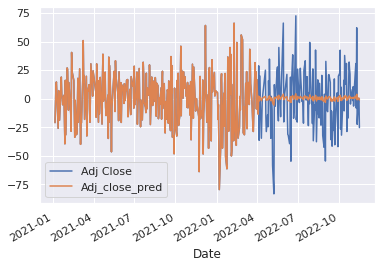

In [27]:
data_diff.loc[:,['Adj Close','Adj_close_pred']].plot()

Our network is a Chicken...doesn't dare to make real change predictions

In [28]:
# let's look at the sign for the "mini momevements" that are produced
pred_sign = pd.DataFrame(zip(testPredict.flatten(), y_test.flatten())) > 0

Basically: True if > 0, else False

In [29]:
pred_sign

,0,1
0,True,False
1,False,True
2,True,True
3,True,False
4,False,False
...,...,...
149,True,False
150,False,True
151,True,False
152,True,False


What's the share where the predicted sign (direction of change) was the same as reality?

In [30]:
(pred_sign[0] == pred_sign[1]).sum()/len(pred_sign)

0.45454545454545453

## Introducing multi-step

In [31]:
# convert an array of values into a dataset matrix (convenience function to fiddle less around)
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [32]:
# reshape into X=t and Y=t+1
look_back = 5
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

In [33]:
# build the network

model = Sequential()
model.add(LSTM(16, input_shape=(look_back, 1), return_sequences=True))
model.add(LSTM(4, return_sequences=False))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [34]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 5, 16)             1152      
                                                                 
 lstm_2 (LSTM)               (None, 4)                 336       
                                                                 
 dense_1 (Dense)             (None, 1)                 5         
                                                                 
Total params: 1,493
Trainable params: 1,493
Non-trainable params: 0
_________________________________________________________________


In [35]:
model.fit(X_train, y_train, epochs=10, batch_size=1, verbose=2)

Epoch 1/10
305/305 - 5s - loss: 0.0860 - 5s/epoch - 16ms/step
Epoch 2/10
305/305 - 1s - loss: 0.0846 - 1s/epoch - 4ms/step
Epoch 3/10
305/305 - 2s - loss: 0.0847 - 2s/epoch - 7ms/step
Epoch 4/10
305/305 - 2s - loss: 0.0843 - 2s/epoch - 6ms/step
Epoch 5/10
305/305 - 1s - loss: 0.0840 - 1s/epoch - 4ms/step
Epoch 6/10
305/305 - 1s - loss: 0.0846 - 1s/epoch - 4ms/step
Epoch 7/10
305/305 - 1s - loss: 0.0844 - 1s/epoch - 4ms/step
Epoch 8/10
305/305 - 1s - loss: 0.0842 - 1s/epoch - 4ms/step
Epoch 9/10
305/305 - 1s - loss: 0.0843 - 1s/epoch - 4ms/step
Epoch 10/10
305/305 - 1s - loss: 0.0843 - 1s/epoch - 4ms/step


In [36]:
# make predictions
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

5/5 [==============================] - 0s 4ms/step


In [ ]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
y_train = scaler.inverse_transform([y_train])

testPredict = scaler.inverse_transform(testPredict)
y_test = scaler.inverse_transform([y_test])

In [40]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 160.11 RMSE
Test Score: 25.49 RMSE


In [41]:
data_diff['Adj_close_pred'] = data_diff['Adj Close']

In [42]:
data_diff['Adj_close_pred'].iloc[-testPredict.shape[0]:] = testPredict.flatten()

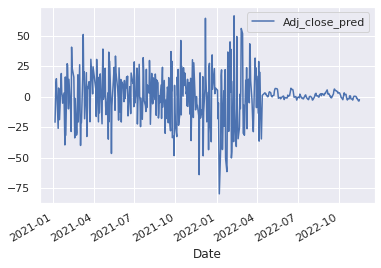

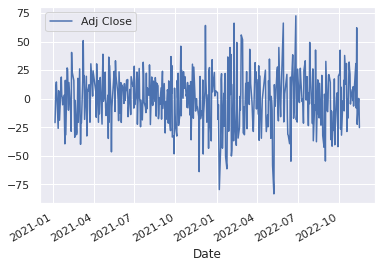

In [43]:
data_diff.loc[:,['Adj_close_pred']].plot()
data_diff.loc[:,['Adj Close']].plot()

In [44]:
pred_sign = pd.DataFrame(zip(testPredict.flatten(), y_test.flatten())) > 0
(pred_sign[0] == pred_sign[1]).sum()/len(pred_sign)

0.527027027027027

Let's use the built in time-series-generator for a bit more compelx case

In [47]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [52]:
start = dt.datetime(2022,5,1)
end = dt.datetime.now()

In [53]:
ETH =  pdr.DataReader('ETH-USD','yahoo', start=start, end=end)
BTC =  pdr.DataReader('BTC-USD','yahoo', start=start, end=end)
ADA =  pdr.DataReader('ADA-USD','yahoo', start=start, end=end)
DOGE =  pdr.DataReader('DOGE-USD','yahoo', start=start, end=end)
BNB =  pdr.DataReader('BNB-USD','yahoo', start=start, end=end)

In [54]:
data = pd.DataFrame({'ETH':ETH['Adj Close'], 
                     'BTC':BTC['Adj Close'], 
                     'ADA':ADA['Adj Close'], 
                     'DOGE': DOGE['Adj Close'], 
                     'BNB':BNB['Adj Close']})

In [55]:
data

,ETH,BTC,ADA,DOGE,BNB
Date,,,,,
2022-05-01,2827.756104,38469.093750,0.790344,0.132773,390.281982
2022-05-02,2857.410400,38529.328125,0.781529,0.130938,389.670654
2022-05-03,2783.476318,37750.453125,0.771145,0.129520,383.475800
2022-05-04,2940.644775,39698.371094,0.896942,0.135809,402.502655
2022-05-05,2749.213135,36575.140625,0.791152,0.128430,378.773621
...,...,...,...,...,...
2022-11-12,1255.268311,16799.185547,0.339144,0.088039,282.341278
2022-11-13,1221.819214,16353.365234,0.330127,0.084893,276.579437
2022-11-14,1241.604248,16618.199219,0.331849,0.085879,278.578430


In [56]:
data = data.sort_index(ascending=True)

In [57]:
data['ADA_shift'] = data['ADA'].shift(-1, fill_value=data['ADA'].iloc[-1])

In [58]:
test_size = int(len(data) * 0.2) # the test data will be 20% (0.2) of the entire data
train = data.iloc[:-test_size,:].copy() 
# the copy() here is important, it will prevent us from getting: SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame. Try using .loc[row_index,col_indexer] = value instead
test = data.iloc[-test_size:,:].copy()
print(train.shape, test.shape)

(160, 6) (40, 6)


In [59]:
train

,ETH,BTC,ADA,DOGE,BNB,ADA_shift
Date,,,,,,
2022-05-01,2827.756104,38469.093750,0.790344,0.132773,390.281982,0.781529
2022-05-02,2857.410400,38529.328125,0.781529,0.130938,389.670654,0.771145
2022-05-03,2783.476318,37750.453125,0.771145,0.129520,383.475800,0.896942
2022-05-04,2940.644775,39698.371094,0.896942,0.135809,402.502655,0.791152
2022-05-05,2749.213135,36575.140625,0.791152,0.128430,378.773621,0.783359
...,...,...,...,...,...,...
2022-10-03,1323.439209,19623.580078,0.427998,0.060384,287.031982,0.435765
2022-10-04,1362.126587,20336.843750,0.435765,0.065962,296.298462,0.431273
2022-10-05,1352.837158,20160.716797,0.431273,0.064735,294.137665,0.428687


In [90]:
X_train = train.iloc[:,:5].values
y_train = train.iloc[:,5].values

X_test = test.iloc[:,:5].values
y_test = test.iloc[:,5].values

In [91]:
x_scaler = MinMaxScaler(feature_range=(-1, 1))
y_scaler = MinMaxScaler(feature_range=(-1, 1))

In [92]:
X_train = x_scaler.fit_transform(X_train)
y_train = y_scaler.fit_transform(y_train.reshape(-1,1))

X_test = x_scaler.transform(X_test)
y_test = y_scaler.transform(y_test.reshape(-1,1))

In [93]:
n_input = 5 #how many samples/rows/timesteps to look in the past in order to forecast the next sample
n_features= X_train.shape[1] # how many predictors/Xs/features we have to predict y
b_size = 32 # Number of timeseries samples in each batch
generator = TimeseriesGenerator(X_train, y_train, length=n_input, batch_size=b_size)


In [94]:
print(generator[0][0].shape)

(32, 5, 5)


In [95]:
model = Sequential()
model.add(LSTM(150, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 150)               93600     
                                                                 
 dense_3 (Dense)             (None, 1)                 151       
                                                                 
Total params: 93,751
Trainable params: 93,751
Non-trainable params: 0
_________________________________________________________________


In [96]:
model.fit(generator,epochs=5)

Epoch 1/5
5/5 [==============================] - 2s 12ms/step - loss: 0.3937
Epoch 2/5
5/5 [==============================] - 0s 11ms/step - loss: 0.2314
Epoch 3/5
5/5 [==============================] - 0s 14ms/step - loss: 0.0867
Epoch 4/5
5/5 [==============================] - 0s 13ms/step - loss: 0.0530
Epoch 5/5
5/5 [==============================] - 0s 12ms/step - loss: 0.0670


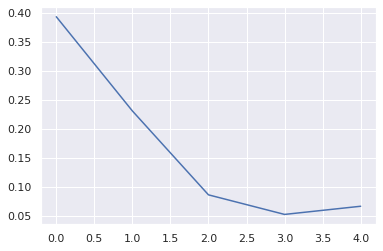

In [97]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch);

In [98]:
test_generator = TimeseriesGenerator(X_test, np.zeros(len(X_test)), length=n_input, batch_size=b_size)
print(test_generator[0][0].shape)

(32, 5, 5)


In [99]:
y_pred_scaled = model.predict(test_generator)
y_pred = y_scaler.inverse_transform(y_pred_scaled)
y_test = y_scaler.inverse_transform(y_test)
results = pd.DataFrame({'y_true':y_test.flatten()[n_input:],'y_pred':y_pred.flatten()})
print(results)

2/2 [==============================] - 0s 8ms/step
      y_true    y_pred
0   0.366851  0.392403
1   0.363744  0.387548
2   0.370281  0.381105
3   0.372345  0.377409
4   0.361820  0.376110
5   0.350032  0.376532
6   0.340254  0.375509
7   0.349077  0.374254
8   0.351409  0.372730
9   0.362099  0.370530
10  0.357857  0.367475
11  0.401988  0.368669
12  0.403492  0.370800
13  0.388697  0.380967
14  0.404507  0.395072
15  0.419778  0.406561
16  0.406047  0.420363
17  0.406336  0.445196
18  0.401402  0.461276
19  0.386076  0.474705
20  0.389420  0.490768
21  0.421525  0.493681
22  0.426735  0.488999
23  0.403005  0.491032
24  0.404259  0.492160
25  0.371834  0.490598
26  0.317837  0.490278
27  0.368977  0.477505
28  0.354667  0.444503
29  0.339144  0.423786
30  0.330127  0.401763
31  0.331849  0.380502
32  0.337009  0.370510
33  0.329081  0.377400
34  0.329081  0.371246


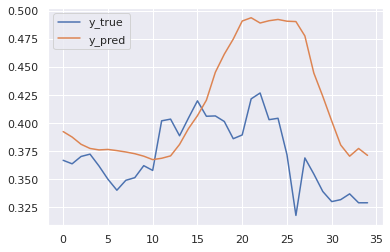

In [100]:
results.plot()

In [101]:
pred_sign = results.diff(1) > 0

In [102]:
pred_sign.y_true == pred_sign.y_pred

0      True
1      True
2     False
3     False
4      True
5     False
6      True
7     False
8     False
9     False
10     True
11     True
12     True
13    False
14     True
15     True
16    False
17     True
18    False
19    False
20     True
21     True
22    False
23    False
24     True
25     True
26     True
27    False
28     True
29     True
30     True
31    False
32    False
33    False
34     True
dtype: bool

In [103]:
(pred_sign.y_true == pred_sign.y_pred).sum()/len(pred_sign)

0.5428571428571428

## From here some experimental backtesting...

In [104]:
data['prediction'] = 0

In [105]:
data['prediction'][-len(results.diff(1).y_pred):] = results.diff(1).y_pred

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [106]:
data['signal'] = 0

In [107]:
data['signal'][-len(results.diff(1).y_pred):] = [-1 if i <= 0 else 1 for i in results.diff(1).y_pred]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [108]:
data['ADA_diff'] = data['ADA'].diff(1)

In [109]:
data

,ETH,BTC,ADA,DOGE,BNB,ADA_shift,prediction,signal,signal_adj,ADA_diff
Date,,,,,,,,,,
2022-05-01,2827.756104,38469.093750,0.790344,0.132773,390.281982,0.781529,0.000000,0,0.0,NaN
2022-05-02,2857.410400,38529.328125,0.781529,0.130938,389.670654,0.771145,0.000000,0,0.0,-0.008815
2022-05-03,2783.476318,37750.453125,0.771145,0.129520,383.475800,0.896942,0.000000,0,0.0,-0.010384
2022-05-04,2940.644775,39698.371094,0.896942,0.135809,402.502655,0.791152,0.000000,0,0.0,0.125797
2022-05-05,2749.213135,36575.140625,0.791152,0.128430,378.773621,0.783359,0.000000,0,0.0,-0.105790
...,...,...,...,...,...,...,...,...,...,...
2022-11-12,1255.268311,16799.185547,0.339144,0.088039,282.341278,0.330127,-0.022023,-1,0.0,-0.015523
2022-11-13,1221.819214,16353.365234,0.330127,0.084893,276.579437,0.331849,-0.021261,-1,0.0,-0.009017
2022-11-14,1241.604248,16618.199219,0.331849,0.085879,278.578430,0.337009,-0.009992,-1,0.0,0.001722


In [110]:
data['signal_adj'] = data.apply(lambda t: 0 if abs(t['prediction']) < 0.02 else t['signal'], axis=1)

In [111]:
data

,ETH,BTC,ADA,DOGE,BNB,ADA_shift,prediction,signal,signal_adj,ADA_diff
Date,,,,,,,,,,
2022-05-01,2827.756104,38469.093750,0.790344,0.132773,390.281982,0.781529,0.000000,0,0.0,NaN
2022-05-02,2857.410400,38529.328125,0.781529,0.130938,389.670654,0.771145,0.000000,0,0.0,-0.008815
2022-05-03,2783.476318,37750.453125,0.771145,0.129520,383.475800,0.896942,0.000000,0,0.0,-0.010384
2022-05-04,2940.644775,39698.371094,0.896942,0.135809,402.502655,0.791152,0.000000,0,0.0,0.125797
2022-05-05,2749.213135,36575.140625,0.791152,0.128430,378.773621,0.783359,0.000000,0,0.0,-0.105790
...,...,...,...,...,...,...,...,...,...,...
2022-11-12,1255.268311,16799.185547,0.339144,0.088039,282.341278,0.330127,-0.022023,-1,-1.0,-0.015523
2022-11-13,1221.819214,16353.365234,0.330127,0.084893,276.579437,0.331849,-0.021261,-1,-1.0,-0.009017
2022-11-14,1241.604248,16618.199219,0.331849,0.085879,278.578430,0.337009,-0.009992,-1,0.0,0.001722


In [112]:
# Set the initial capital
initial_capital= float(10000.0)

In [113]:
# Create a DataFrame `positions`
positions = pd.DataFrame(index=data.index).fillna(0.0)

In [114]:
# Buy a 100 shares
positions['ADA'] = 100*data['signal_adj']   

In [115]:
# Initialize the portfolio with value owned   
portfolio = positions.multiply(data['ADA'], axis=0)

In [116]:
# Store the difference in shares owned 
pos_diff = positions.diff()

# Add `holdings` to portfolio
portfolio['holdings'] = (positions.multiply(data['ADA'], axis=0)).sum(axis=1)

# Add `cash` to portfolio
portfolio['cash'] = initial_capital - (pos_diff.multiply(data['ADA'], axis=0)).sum(axis=1).cumsum()   

# Add `total` to portfolio
portfolio['total'] = portfolio['cash'] + portfolio['holdings']

# Add `returns` to portfolio
portfolio['returns'] = portfolio['total'].pct_change()

# Print the first lines of `portfolio`
print(portfolio.head())

            ADA  holdings     cash    total  returns
Date                                                
2022-05-01  0.0       0.0  10000.0  10000.0      NaN
2022-05-02  0.0       0.0  10000.0  10000.0      0.0
2022-05-03  0.0       0.0  10000.0  10000.0      0.0
2022-05-04  0.0       0.0  10000.0  10000.0      0.0
2022-05-05  0.0       0.0  10000.0  10000.0      0.0


In [117]:
# Print the last lines of `portfolio`
portfolio.tail() 

,ADA,holdings,cash,total,returns
Date,,,,,
2022-11-12,-33.914399,-33.914399,10035.847902,10001.933503,0.000155
2022-11-13,-33.012700,-33.012700,10035.847902,10002.835202,0.000090
2022-11-14,0.000000,0.000000,10002.663001,10002.663001,-0.000017
2022-11-15,0.000000,0.000000,10002.663001,10002.663001,0.000000
2022-11-16,0.000000,0.000000,10002.663001,10002.663001,0.000000
